In [ ]:
from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import nn
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np

!pip install -q captum

from captum.attr import *
from captum.attr import visualization as viz

!pip install -q umap-learn[plot]

import umap
import umap.plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model = torch.load('drive/MyDrive/MNIST Feature Attribution/mnist-0123-only')
model.eval()
model.zero_grad()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


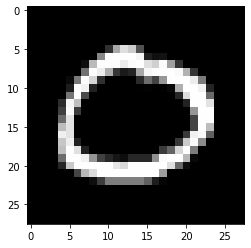

In [ ]:
train_ds = MNIST("mnist", train=True, download=True, transform=transforms.ToTensor())
test_ds = MNIST("mnist", train=False, download=True, transform=transforms.ToTensor())

isolated_indexes = (test_ds.targets == 0) | (test_ds.targets == 1) | (test_ds.targets == 2) | (test_ds.targets == 3)
test_ds.targets = test_ds.targets[isolated_indexes]
test_ds.data = test_ds.data[isolated_indexes]

test_dl = DataLoader(test_ds, batch_size=500, shuffle=True, )
images, labels = iter(test_dl).next()
import matplotlib.pyplot as plt
image = images[0]
plt.imshow(image.squeeze(), cmap='gray')

In [ ]:
# Create feature mask that groups 7x7 blocks of pixels 
pattern1 = ([0] * 7 + [1] * 7 + [2] * 7 + [3] * 7) * 7
pattern2 = ([4] * 7 + [5] * 7 + [6] * 7 + [7] * 7) * 7
pattern3 = ([8] * 7 + [9] * 7 + [10] * 7 + [11] * 7) * 7
pattern4 = ([12] * 7 + [13] * 7 + [14] * 7 + [15] * 7) * 7
feature_mask_4x4 = torch.tensor(pattern1 + pattern2 + pattern3 + pattern4).reshape(28, 28).unsqueeze(0)

In [ ]:
# Create feature mask that groups 2x2 blocks of pixels
base_matrix = np.array([0] * 4).reshape(2,2)
base_row_list = []
for i in range(14):
  base_row_list.append(base_matrix + i)
base_row = np.hstack((tuple(base_row_list)))
all_rows = []
for i in range(14):
  all_rows.append(base_row + (14 * i))

feature_mask_14x14 = np.vstack(tuple(all_rows))
feature_mask_14x14 = torch.tensor(feature_mask_14x14).unsqueeze(0)

In [ ]:
feature_mask_14x14.shape

torch.Size([1, 28, 28])

In [ ]:
svs = ShapleyValueSampling(model)

# Shapley values are EXPENSIVE to computer, for demonstration purposes just feed in 50 images and their respective labels,
# and reduce sampling from default 25 to 10
attributions = svs.attribute(images[:50], target=labels[:50], feature_mask=feature_mask_14x14, n_samples = 10, show_progress = True)

Shapley Value Sampling attribution: 100%|██████████| 1961/1961 [05:06<00:00,  6.40it/s]


In [ ]:
torch.save(attributions, "drive/MyDrive/MNIST Feature Attribution/ShapleyValueSamplingAttributions.pt")

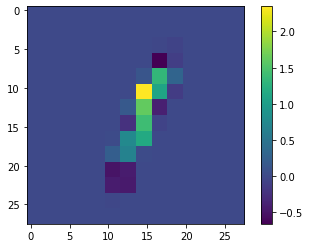

In [ ]:
attribution = attributions[10]
plt.imshow(attribution.squeeze())
plt.colorbar()

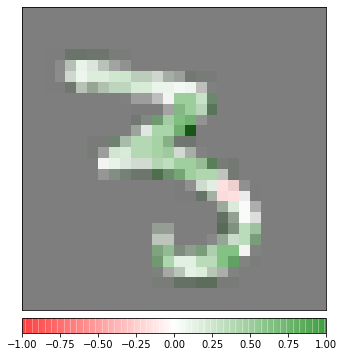

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f90112d6dd0>)

In [ ]:
attribution = np.transpose(attributions[1].detach().numpy(), (1,2,0))
image = np.transpose(images[1].detach().numpy(), (1,2,0))

viz.visualize_image_attr(attribution, image, method="blended_heat_map", show_colorbar=True, sign="all")

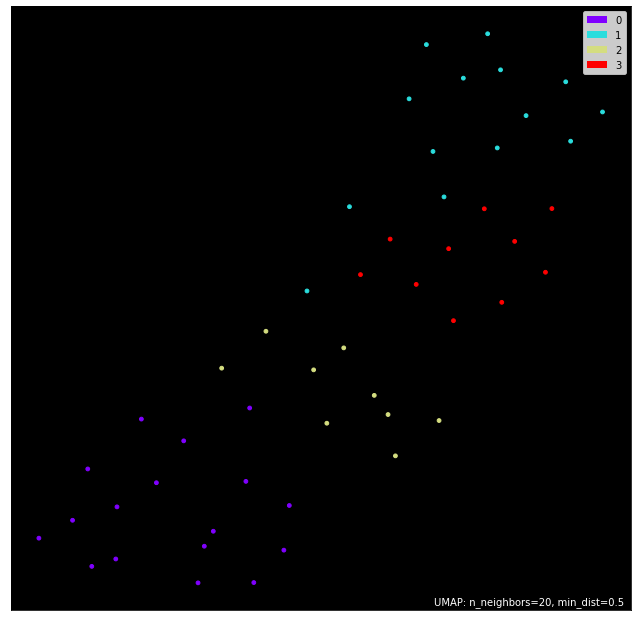

In [ ]:
mapper = umap.UMAP(n_neighbors = 20,min_dist=0.5, random_state=193).fit(torch.reshape(attributions.squeeze(), (50, 784)))

umap.plot.points(mapper, labels=labels[:50], theme="fire")